# Pattern recognition CW2

In [2]:
from scipy.io import loadmat
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
import time
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import metric_learn
from numpy import linalg as calc_eigen
from sklearn.preprocessing import normalize as normalize_vectors
import pandas as pd
import pylab as pl
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn import preprocessing
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist
from scipy.optimize import minimize

### Import file with 6 main components:

In [3]:
""" 
camId : which camera was used to get the shot (1 or 2)
filelist: names of the images (with format x_label_camId_index.png)
labels: class of the image (which person's image is it?)
query_idx: indexes of test set
gallery_idx: indexes of test set used for kNN 
train_idx: indexes of training and validation set
"""   
train_idxs = loadmat('cuhk03_new_protocol_config_labeled.mat')

### Import file with the feature vectors of all images:

In [4]:
import json
with open('PR_data/feature_data.json', 'r') as f:
    features = json.load(f)
features_np = np.array(features) #list of features converted to an array 
features_np.shape

(14096, 2048)

In [5]:
gallery_indices = train_idxs['gallery_idx'].flatten() - 1
gallery_images = features_np[gallery_indices]
gallery_labels = train_idxs['labels'][gallery_indices]

query_indices = train_idxs['query_idx'].flatten() - 1
query_images = features_np[query_indices]
query_labels = train_idxs['labels'][query_indices]

training_indices = train_idxs['train_idx'].flatten() - 1
training_images = features_np[training_indices]
training_labels = train_idxs['labels'][training_indices]

In [6]:
def calculateAverageFace(X):
    """
    takes the training data set as input 
    and returns the average face
    """
    average_face= np.mean(X, axis=0)
    #plt.figure()
    #plt.title("Average Face")
    #plt.imshow(np.resize(average_face, (46, 56)).T, cmap='gray')
    return average_face

def normalize(X, AvgFace):
    """
    takes the training data set and average face as input 
    and returns the normalized training data set

    """
    Q = np.empty((len(X[:,0]),len(X[0, :])))
    for index, face in enumerate(X):
        Q[index] = face - AvgFace
    return Q.T

def calculateCovarianceMatrix(Q):
    return np.matmul(Q,Q.T)/len(Q[0,:])

def calculateLowDimCovarianceMatrix(Q):
    return np.matmul(Q.T,Q)/len(Q[0,:])

def calculateEigenValuesAndVectors(S):
    """
    Takes covariance matrix as input
    and returns eigen values and vectors
    """
    v, w =  calc_eigen.eigh(S)
    #eigen_vectors[:,i] --> eigen_values[i]
    #eigen vector corresponding to eigen value

    #flips left to right... ascending to descending
    v = np.flip(v, axis=0) #turn ascending into descending
    w = np.flip(w, axis=1) #turn ascending into descending
    return v, w

def calculateWeights(Q, U):
    """
    takes input the normalized input and the eigen space
    outputs the weights of the normalized input
    """
    N = len(Q[0,:])
    W = np.empty((N,len(U[0, :])))
    for index, image in enumerate(Q.T):
        W[index] = np.matmul(image, U)
    return W

def calculateWeights2(Q, U):
    """
    alternative method to calculate weights
    """
    N = len(Q[0,:])
    W2 = np.empty((N,len(U[0, :])))
    W2 = np.matmul(Q.T, top_eigen_vectors)
    return W2

def printImage(face, title, saved_file):
    """
    takes input as the face you want to print, the title of the image, and the location of the file
    you would like to save the image to. 
    """
    plt.figure()
    plt.imshow(np.resize(face, (46, 56)).T, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.savefig(saved_file, bbox_inches='tight')   # save the figure to file
    plt.show()
    plt.close() 
    
def plotEigenValueGraph(v, points):
    """
    plots eigen values against inrementing the number of eigen values used
    in descending order
    """
    y_points = [value for value in v[:points]]
    x_points = [i for i in range(points)]
    plt.xlabel('Number of Eigen Values')
    plt.ylabel('Eigen Values')
    plt.title('Plot of Eigen Values in Descending Order')
    plt.plot(x_points, y_points)
    plt.savefig('eigenvalues.png', bbox_inches='tight')   # save the figure to file
    plt.show()
    plt.close() 

### PCA on Training, Gallery, and Query Set

In [7]:
def PCA(X, M):
    AvgFace = calculateAverageFace(X)
    A = normalize(X, AvgFace)
    S = calculateCovarianceMatrix(A)
    eigen_values, eigen_vectors = calculateEigenValuesAndVectors(S)
    x_points = 1000
    #plotEigenValueGraph(eigen_values, x_points)
    variance_captured = np.sum(eigen_values[:M])*100/np.sum(eigen_values)
    print("Variance Captured by top ", M, " features is ", variance_captured, ".")
    top_eigen_vectors = eigen_vectors[:, :M]
    reduced_dim_X =  calculateWeights(A, top_eigen_vectors)
    return reduced_dim_X, top_eigen_vectors, AvgFace

In [146]:
M = 100
reduced_training_images, eigen_space, AvgFace = PCA(training_images, M)

Variance Captured by top  100  features is  92.92050565369443 .


In [147]:
reduced_gallery_images = calculateWeights(normalize(gallery_images, AvgFace), eigen_space)
reduced_query_images = calculateWeights(normalize(query_images, AvgFace), eigen_space)

## kNN Classification for query set on gallery set

In [8]:
def calculate_recall_index(value, recall): #only used in calcAP function below
    for index, recall_val in enumerate(recall):
        if recall_val >= value:
            return index
    
def calcAP(true_label, rank_k_labels):
    correct_list = [true_label == this_label for this_label in rank_k_labels]
    precision = []
    recall = []
    for i in range(len(rank_k_labels)):
        precision.append(sum(correct_list[:i+1])/len(correct_list[:i+1]))
        recall.append(sum(correct_list[:i+1])/sum(correct_list))
    max_list = []
    for i in range(11):
        recall_index = calculate_recall_index(i/10, recall)
        max_list.append(max(precision[recall_index:]))
    #print(max_list)
    return np.mean(max_list)

In [25]:
def remove_indices(n_indices, query_index):
    query_label_and_camId = (train_idxs['labels'][query_index][0], train_idxs['camId'][query_index][0])
    list_of_gallery_label_and_camId = [(label[0], camId[0]) for label, camId in zip(train_idxs['labels'][n_indices], train_idxs['camId'][n_indices])] 
    final_list = list(filter(lambda a: a != query_label_and_camId, list_of_gallery_label_and_camId))
    #print(train_idxs['filelist'][n_indices][:15])
    return [tup[0] for tup in final_list]#, [tup[1] for tup in final_list]

def get_accuracy(k, N, query_images, gallery_images):
    list_of_truths = []
    AP_vals = []
    start = time.time() #time tracking - start time of process
    neigh = NearestNeighbors(n_neighbors=N, n_jobs=-1)
    neigh.fit(gallery_images)   #new_gallery_labels)
    for index, query_index in enumerate(query_indices.tolist()):
        if (index % 100 == 0):
            print("Index: ", index, " & time taken: ", time.time() - start)
        N_distances, N_indices = neigh.kneighbors(query_images[index].reshape(1, len(query_images[0, :])))
        #print(N_distances.shape)
        #print('hi')
        #print(N_indices)
        forLoopStart = time.time()
        topN_gallery_indices = (gallery_indices[N_indices[0]]).tolist()
        reduced_topN_labels = remove_indices(topN_gallery_indices, query_index)
        #print(len(topN_gallery_indices), len(reduced_topN_labels))
        #print((query_labels[query_index][0], reduced_topN_labels[:k]))
        #print(query_labels[index][0], query_indices[index])
        #print(reduced_topN_labels[:k])
        #print(camIds[:k])
        if query_labels[index][0] in reduced_topN_labels[:k]:
            list_of_truths.append(True)
        else:
            list_of_truths.append(False)
        AP = calcAP(query_labels[index][0], reduced_topN_labels[:k])
        AP_vals.append(AP)
    #over-all accuracy  
    acc = sum(list_of_truths)/len(list_of_truths)
    #print(acc)
    return acc, np.mean(AP_vals)

In [14]:
N=100
k = [1, 2, 3, 4, 5, 6, 8, 11, 14, 19, 26, 34, 45, 65, 85, 100]
baseline_results = []
for k_val in k: 
    print("For rank ", k_val, ": ")
    accuracy, mAP = get_accuracy(k_val, N, query_images, gallery_images)
    results = [k_val, accuracy, mAP]
    baseline_results.append(results)
    print(results)
    

For rank  1 : 
Index:  0  & time taken:  2.1827785968780518


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':


Index:  100  & time taken:  17.571115732192993
Index:  200  & time taken:  35.40209436416626
Index:  300  & time taken:  49.51718807220459
Index:  400  & time taken:  64.7836856842041
Index:  500  & time taken:  75.22849178314209
Index:  600  & time taken:  85.63636827468872
Index:  700  & time taken:  96.04140877723694
Index:  800  & time taken:  106.43112397193909
Index:  900  & time taken:  116.89226341247559
Index:  1000  & time taken:  127.29343581199646
Index:  1100  & time taken:  137.66773867607117
Index:  1200  & time taken:  148.03430795669556
Index:  1300  & time taken:  158.78056025505066
[1, 0.47, 0.47]
For rank  2 : 
Index:  0  & time taken:  0.9939818382263184
Index:  100  & time taken:  11.820737600326538
Index:  200  & time taken:  22.72847056388855
Index:  300  & time taken:  33.518255949020386
Index:  400  & time taken:  44.52291440963745
Index:  500  & time taken:  55.5569384098053
Index:  600  & time taken:  66.59140849113464
Index:  700  & time taken:  77.53325247

Index:  1000  & time taken:  119.24550914764404
Index:  1100  & time taken:  130.41961002349854
Index:  1200  & time taken:  141.599378824234
Index:  1300  & time taken:  153.2544379234314
[34, 0.8714285714285714, 0.49033161883060483]
For rank  45 : 
Index:  0  & time taken:  0.9717006683349609
Index:  100  & time taken:  12.914498090744019
Index:  200  & time taken:  24.95019769668579
Index:  300  & time taken:  37.076090574264526
Index:  400  & time taken:  49.20830488204956
Index:  500  & time taken:  61.355066776275635
Index:  600  & time taken:  73.45353245735168
Index:  700  & time taken:  85.55447840690613
Index:  800  & time taken:  97.6679162979126
Index:  900  & time taken:  109.80105304718018
Index:  1000  & time taken:  121.91180896759033
Index:  1100  & time taken:  134.03330898284912
Index:  1200  & time taken:  145.95392680168152
Index:  1300  & time taken:  158.09110474586487
[45, 0.8907142857142857, 0.48611382275125997]
For rank  65 : 
Index:  0  & time taken:  0.94190

In [58]:
def calc_acc_all_k(all_reduced_topN_labels, query_labels, k_val):
    all_accs = []
    for k in range(1, k_val):
        this_k_acc = []
        for index, reduced_topN_labels in enumerate(all_reduced_topN_labels):
            this_k_acc.append(query_labels[index][0] in reduced_topN_labels[:k])
        all_accs.append(sum(this_k_acc)/len(this_k_acc))
    return all_accs

def calc_AP_all_k(all_reduced_topN_labels, query_labels, k_val):
    all_AP = []
    for k in range(1, k_val):
        print('k=', k)
        AP_vals = []
        for index, reduced_topN_labels in enumerate(all_reduced_topN_labels):
            AP = calcAP(query_labels[index][0], reduced_topN_labels[:k])
            AP_vals.append(AP)
        all_AP.append(np.mean(AP_vals))
    all_AP = np.array(all_AP)
    return all_AP
    
def get_accuracy_improved(k, N, query_images, gallery_images):
    list_of_truths = []
    AP_vals = []
    start = time.time() #time tracking - start time of process
    neigh = NearestNeighbors(n_neighbors=N, n_jobs=-1)
    neigh.fit(gallery_images)   #new_gallery_labels)
    all_labels = []
    all_N_neighbours = []
    all_accs = []
    all_reduced_topN_labels = []
    for index, query_index in enumerate(query_indices.tolist()):
        if (index % 100 == 0):
            print("Index: ", index, " & time taken: ", time.time() - start)
        N_distances, N_indices = neigh.kneighbors(query_images[index].reshape(1, len(query_images[0, :])))
        #print(N_distances.shape)
        #print('hi')
        #print(N_indices)
        forLoopStart = time.time()
        topN_gallery_indices = (gallery_indices[N_indices[0]]).tolist()
        reduced_topN_labels = remove_indices(topN_gallery_indices, query_index)
        #print(len(topN_gallery_indices), len(reduced_topN_labels))
        #print((query_labels[query_index][0], reduced_topN_labels[:k]))
        #print(query_labels[index][0], query_indices[index])
        #print(reduced_topN_labels[:k])
        #print(camIds[:k])
        #if query_labels[index][0] in reduced_topN_labels[:k]:
        #    list_of_truths.append(True)
        #else:
        #    list_of_truths.append(False)
        all_reduced_topN_labels.append(reduced_topN_labels)
        AP = calcAP(query_labels[index][0], reduced_topN_labels[:k])
        AP_vals.append(AP)
        acc_all_k = calc_acc_all_k(query_labels[index][0], reduced_topN_labels)
        all_accs.append(acc_all_k)
        #this_label, N_neighbours = query_labels[index][0], reduced_topN_labels
        #all_labels.append(this_label)
        #all_N_neighbours.append(N_neighbours)
    #all_accs, all_APs = calc_acc_AP_all_k(all_reduced_topN_labels, query_labels) #all_accs = [] where each element is the acc for k=index, etc.
    #over-all accuracy
    return all_reduced_topN_labels
    acc_k_vals = calc_acc_k_vals(all_labels, all_N_neighbours)
    #acc = sum(list_of_truths)/len(list_of_truths)
    print(np.array(all_accs))
    #print(acc)
    return all_accs, np.mean(all_APs, axis=1) #maybe axis=0?

In [46]:
N = 110

baseline_results_improved_k = []
print("For rank ", k_val, ": ")
all_reduced_topN_labels = get_accuracy_improved(10, N, query_images, gallery_images)
#results = [k_val, accuracy_array, mAP]
#baseline_results_improved~_k.append(results)
#print(results)


For rank  1 : 
Index:  0  & time taken:  0.9557905197143555


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':


Index:  100  & time taken:  11.366840362548828
Index:  200  & time taken:  21.771477222442627
Index:  300  & time taken:  32.20358943939209
Index:  400  & time taken:  42.64135980606079
Index:  500  & time taken:  53.045504093170166
Index:  600  & time taken:  63.45678114891052
Index:  700  & time taken:  73.86095714569092
Index:  800  & time taken:  84.27045035362244
Index:  900  & time taken:  94.67671370506287
Index:  1000  & time taken:  105.10857510566711
Index:  1100  & time taken:  115.52924394607544
Index:  1200  & time taken:  125.93397068977356
Index:  1300  & time taken:  136.33827090263367


In [127]:
all_accs = calc_acc_all_k(all_reduced_topN_labels, query_labels, 101)
print(all_accs)
#all_AP = calc_AP_all_k(all_reduced_topN_labels, query_labels, 101)
#print(all_AP)

[0.47, 0.5457142857142857, 0.5964285714285714, 0.6392857142857142, 0.6685714285714286, 0.6928571428571428, 0.7114285714285714, 0.7235714285714285, 0.7371428571428571, 0.7492857142857143, 0.7585714285714286, 0.7678571428571429, 0.7771428571428571, 0.785, 0.7907142857142857, 0.7985714285714286, 0.8064285714285714, 0.8157142857142857, 0.8228571428571428, 0.8321428571428572, 0.835, 0.8371428571428572, 0.84, 0.8428571428571429, 0.8478571428571429, 0.8528571428571429, 0.8564285714285714, 0.8592857142857143, 0.8607142857142858, 0.8635714285714285, 0.8678571428571429, 0.8692857142857143, 0.8692857142857143, 0.8714285714285714, 0.8721428571428571, 0.8721428571428571, 0.8728571428571429, 0.875, 0.8778571428571429, 0.8807142857142857, 0.8821428571428571, 0.885, 0.8871428571428571, 0.8892857142857142, 0.8907142857142857, 0.8907142857142857, 0.8914285714285715, 0.8935714285714286, 0.8942857142857142, 0.8978571428571429, 0.8985714285714286, 0.9014285714285715, 0.905, 0.9057142857142857, 0.9085714285

In [ ]:
## DELETE THIS WHOLE CELL


7, 58     1_007_1_02
[22, 7, 382, 22, 7, 303, 7, 854, 7, 441]
[1, 2, 1, 1, 2, 1, 2, 2, 2, 1]
[[array(['1_007_2_09.png'], dtype='<U14')]
 [array(['1_007_2_08.png'], dtype='<U14')]
 [array(['1_007_2_07.png'], dtype='<U14')]
 [array(['1_007_2_10.png'], dtype='<U14')]
 [array(['1_319_2_08.png'], dtype='<U14')]
 [array(['1_319_2_06.png'], dtype='<U14')]
 [array(['1_319_2_07.png'], dtype='<U14')]
 [array(['1_319_2_09.png'], dtype='<U14')]
 [array(['1_022_1_02.png'], dtype='<U14')]
 [array(['1_022_1_03.png'], dtype='<U14')]
 #[array(['1_426_1_03.png'], dtype='<U14')]]


#7, 62 (camId:2)    1_007_2_06
#[319, 319, 7, 319, 7, 7, 7, 319, 22, 22]
#[2, 2, 1, 2, 1, 1, 1, 2, 1, 1]
#[[array(['1_011_1_02.png'], dtype='<U14')]
# [array(['1_011_1_04.png'], dtype='<U14')]
# [array(['1_011_1_01.png'], dtype='<U14')]
# [array(['1_390_2_10.png'], dtype='<U14')]
# [array(['1_738_1_03.png'], dtype='<U14')]
# [array(['1_011_2_10.png'], dtype='<U14')]
# [array(['1_738_1_02.png'], dtype='<U14')]
# [array(['1_011_2_09.png'], dtype='<U14')]
# [array(['1_055_1_04.png'], dtype='<U14')]
# [array(['1_011_2_07.png'], dtype='<U14')]]


11, 99 (camId(1))     1_011_1_03 
[390, 738, 11, 738, 11, 55, 11, 625, 211, 42]
[2, 1, 2, 1, 2, 1, 2, 1, 2, 2]
[[array(['1_011_2_07.png'], dtype='<U14')]
 [array(['1_011_2_09.png'], dtype='<U14')]
 [array(['1_011_2_08.png'], dtype='<U14')]
 [array(['1_011_2_10.png'], dtype='<U14')]
 [array(['1_738_2_08.png'], dtype='<U14')]
 [array(['1_055_1_04.png'], dtype='<U14')]
 [array(['1_721_2_07.png'], dtype='<U14')]
 [array(['1_721_2_08.png'], dtype='<U14')]
 [array(['1_721_2_09.png'], dtype='<U14')]]
 [array(['1_401_2_08.png'], dtype='<U14')]

In [270]:
new_gallery_images

array([[ 7.51665988e-02, -2.13931898e-01,  1.82375075e-01, ...,
         1.17935912e-03, -1.83009646e-03,  6.44215924e-04],
       [ 4.98373454e-02, -2.76704402e-01,  2.07031763e-01, ...,
         1.81335126e-03, -8.94494709e-04, -9.35844399e-04],
       [ 2.97090900e-02, -2.46814502e-01,  1.84029012e-01, ...,
         2.54448802e-03, -1.30504720e-03,  4.06488781e-05],
       ...,
       [ 1.97073951e-02,  1.27395267e-01,  1.59405793e-01, ...,
        -2.73751627e-03, -6.85079450e-04, -2.11712592e-03],
       [ 4.31737487e-02,  1.83651074e-01,  1.58359543e-01, ...,
        -1.93050413e-04,  1.64827463e-03,  4.32506008e-03],
       [ 6.89824342e-02,  1.80058167e-01,  1.63204092e-01, ...,
         6.04884920e-04,  1.03840411e-03,  2.51251101e-03]])

In [334]:
train_idxs['filelist'][58]

array([array(['1_007_1_02.png'], dtype='<U14')], dtype=object)

In [126]:
all_accs

[0.0,
 0.0007142857142857143,
 0.0007142857142857143,
 0.0007142857142857143,
 0.0007142857142857143,
 0.0007142857142857143,
 0.002142857142857143,
 0.004285714285714286,
 0.005714285714285714,
 0.005714285714285714,
 0.0064285714285714285,
 0.0064285714285714285,
 0.0064285714285714285,
 0.007142857142857143,
 0.007857142857142858,
 0.007857142857142858,
 0.007857142857142858,
 0.007857142857142858,
 0.008571428571428572,
 0.008571428571428572,
 0.009285714285714286,
 0.009285714285714286,
 0.009285714285714286,
 0.01,
 0.01,
 0.01,
 0.010714285714285714,
 0.010714285714285714,
 0.011428571428571429,
 0.011428571428571429,
 0.011428571428571429,
 0.012142857142857143,
 0.012857142857142857,
 0.012857142857142857,
 0.013571428571428571,
 0.013571428571428571,
 0.013571428571428571,
 0.013571428571428571,
 0.013571428571428571,
 0.013571428571428571,
 0.013571428571428571,
 0.013571428571428571,
 0.013571428571428571,
 0.014285714285714285,
 0.014285714285714285,
 0.014285714285714285,

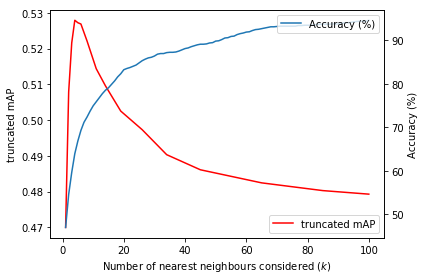

In [140]:
#plot baseline results graph (acc vs k)

def plot_baseline_results(fileName, all_accs, baseline_results):
    fig, ax1 = plt.subplots()
    all_accs = np.array(all_accs)
    #plt.plot(baseline_results[:,0], baseline_results[:,2])
    
    plt.xlabel('Number of nearest neighbours considered ($k$)')
    ax1.set_ylabel('truncated mAP')
    baseline_results = np.array(baseline_results)
    plt.plot(baseline_results[:,0], baseline_results[:,2], color='red')
    #plt.title('Accuracy for varying $k$')
    #plt.grid(b=True, which='both')
    ax1.legend(['truncated mAP'], loc='lower right')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy (%)')  # we already handled the x-label with ax1
    plt.plot(range(1, len(all_accs)+1), all_accs*100)
    ax2.legend(['Accuracy (%)'], loc='upper right')
    fig.tight_layout()
    
    plt.savefig(fileName + '.png', bbox_inches='tight', dpi=300)
    plt.show()
    
plot_baseline_results('baseline_results', all_accs, baseline_results)

### Results for kNN: 

k = 1, Accuracy = 0.47, mAP = 0.47

k = 5, Accuracy = 0.6685714285714286, mAP = 0.5272045454545454

k = 10, Accuracy = 0.7492857142857143, mAP = 0.5169191146155432

In [20]:
def get_accuracy_pca(k, N):
    list_of_truths = []
    AP_vals = []
    start = time.time() #time tracking - start time of process
    neigh = NearestNeighbors(n_neighbors=N, n_jobs=-1)
    neigh.fit(reduced_gallery_images)   #new_gallery_labels)
    for index, query_index in enumerate(query_indices.tolist()):
        if (index % 200 == 0):
            print("Index: ", index, " & time taken: ", time.time() - start)
        N_distances, N_indices = neigh.kneighbors(reduced_query_images[index].reshape(1, len(reduced_query_images[0, :])))
        forLoopStart = time.time()
        topN_gallery_indices = (gallery_indices[N_indices[0]]).tolist()
        reduced_topN_labels = remove_indices(topN_gallery_indices, query_index)
        if query_labels[index][0] in reduced_topN_labels[:k]:
            list_of_truths.append(True)
        else:
            list_of_truths.append(False)
        AP = calcAP(query_labels[index][0], reduced_topN_labels[:k])
        AP_vals.append(AP)
    #over-all accuracy  
    acc = sum(list_of_truths)/len(list_of_truths)
    print(acc)
    return acc, np.mean(AP_vals)

In [142]:
N=100
k = [1, 5, 10]
results2 = []
for k_val in k: 
    print("For rank ", k_val, ": ")
    accuracy, mAP = get_accuracy_pca(k_val, N)
    tup = (k_val, accuracy, mAP)
    results2.append(tup)
    print(tup)

For rank  1 : 
Index:  0  & time taken:  0.02941107749938965


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':


Index:  200  & time taken:  21.079618215560913
Index:  400  & time taken:  42.17799711227417
Index:  600  & time taken:  63.17202019691467
Index:  800  & time taken:  84.27191829681396
Index:  1000  & time taken:  105.21672511100769
Index:  1200  & time taken:  126.23884606361389
0.46714285714285714
(1, 0.46714285714285714, 0.46714285714285714)
For rank  5 : 
Index:  0  & time taken:  0.013506174087524414
Index:  200  & time taken:  20.97689700126648
Index:  400  & time taken:  41.993072271347046
Index:  600  & time taken:  63.114259004592896
Index:  800  & time taken:  84.1421959400177
Index:  1000  & time taken:  105.16470098495483
Index:  1200  & time taken:  126.25219821929932
0.6757142857142857
(5, 0.6757142857142857, 0.5285400432900433)
For rank  10 : 
Index:  0  & time taken:  0.013849973678588867
Index:  200  & time taken:  21.23994207382202
Index:  400  & time taken:  42.65201115608215
Index:  600  & time taken:  63.94959092140198
Index:  800  & time taken:  85.24179100990295


### Results for kNN using PCA: 

k = 1, Accuracy = 0.46714285714285714, mAP = 0.46714285714285714

k = 5, Accuracy = 0.6757142857142857, mAP = 0.5285400432900433

k = 10, Accuracy = 0.7485714285714286, mAP = 0.5152942434549578

## K-means

In [67]:
def img_indices_in_cluster(c, index_and_cluster): 
    gallery_indices_in_cluster = [pair[0] for pair in index_and_cluster if pair[1] == c]
    return gallery_indices_in_cluster

def img_cluster(k, N, c_g_indices, query_index, index):
    list_of_truths = []
    neigh = NearestNeighbors(n_neighbors=N, n_jobs=-1, metric='euclidean')
    neigh.fit(features_np[c_g_indices])   #new_gallery_labels)
    N_distances, N_indices = neigh.kneighbors(query_images[index].reshape(1, -1))
    topN_c_g_indices = (gallery_indices[N_indices[0]]).tolist()
    reduced_topN_labels = remove_indices(topN_c_g_indices, query_index)
    #print(query_labels[index][0], reduced_topN_labels[:k])
    return reduced_topN_labels
    return (query_labels[index][0] in reduced_topN_labels[:k])

def knn_clustering(k, N, index_and_cluster):
    class_success = []
    start = time.time() #time tracking - start time of process
    all_reduced_topN_labels = []
    for index, query_index in enumerate(query_indices.tolist()):
        if (index % 200 == 0):
            print("Index: ", index, " & time taken: ", time.time() - start)
        cluster = kmeans.predict(query_images[index].reshape(1,-1))
        cluster_gallery_indices = img_indices_in_cluster(cluster, index_and_cluster)
        reduced_topN_labels = img_cluster(k, N, cluster_gallery_indices, query_index, index)
        all_reduced_topN_labels.append(reduced_topN_labels)
        #class_success.append(img_cluster(k, N, cluster_gallery_indices, query_index, index))
    return all_reduced_topN_labels
    #over-all accuracy
    acc = sum(class_success)/len(class_success)
    print(acc)
    return acc

In [ ]:
all_accs = calc_acc_all_k(all_reduced_topN_labels, query_labels, 101)
print(all_accs)

In [109]:
total_number_of_labels = len(np.unique(gallery_labels.flatten()))

acc_kmeans_new_2 = []
clusters_2 = [20]
for n_clusters in clusters_2:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(gallery_images)
    index_and_cluster = [(index, label) for index, label in zip(gallery_indices, kmeans.labels_)]
    N = 110
    all_reduced_topN_labels_clustering = knn_clustering(10, N, index_and_cluster)
    all_accs_cluster = calc_acc_all_k(all_reduced_topN_labels_clustering, query_labels, 101)
    acc_kmeans_new_2.append(all_accs_cluster)
    print(all_accs_cluster)

Index:  0  & time taken:  0.0
Index:  200  & time taken:  223.8059160709381
Index:  400  & time taken:  579.8530704975128
Index:  600  & time taken:  880.2893407344818
Index:  800  & time taken:  1203.3730905056
Index:  1000  & time taken:  1401.2129628658295
Index:  1200  & time taken:  1530.7014179229736
[0.0, 0.0007142857142857143, 0.0007142857142857143, 0.0007142857142857143, 0.0007142857142857143, 0.0007142857142857143, 0.002142857142857143, 0.004285714285714286, 0.005714285714285714, 0.005714285714285714, 0.0064285714285714285, 0.0064285714285714285, 0.0064285714285714285, 0.007142857142857143, 0.007857142857142858, 0.007857142857142858, 0.007857142857142858, 0.007857142857142858, 0.008571428571428572, 0.008571428571428572, 0.009285714285714286, 0.009285714285714286, 0.009285714285714286, 0.01, 0.01, 0.01, 0.010714285714285714, 0.010714285714285714, 0.011428571428571429, 0.011428571428571429, 0.011428571428571429, 0.012142857142857143, 0.012857142857142857, 0.012857142857142857, 

In [110]:
len(acc_kmeans_new)

4

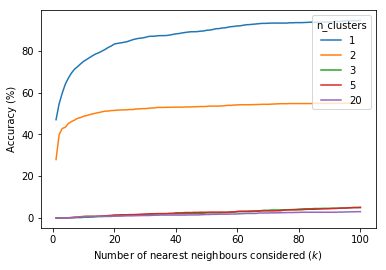

In [124]:
#plot kmeans results graph (acc vs k for different values of n_clusters)
total_number_of_labels = len(np.unique(gallery_labels.flatten()))
clusters = [1, 2, 3, 5, 20]

acc_kmeans = acc_kmeans_new + acc_kmeans_new_2
def plot_kmeans_results(fileName, acc_kmeans):
    fig = plt.figure()
    acc_kmeans = np.array(acc_kmeans)
    for all_accs in acc_kmeans:
        plt.plot(range(1, len(all_accs)+1), all_accs*100)
    
    plt.xlabel('Number of nearest neighbours considered ($k$)')
    plt.ylabel('Accuracy (%)')
    #plt.title('Accuracy for varying $k$')
    #plt.grid(b=True, which='both')
    plt.legend(clusters,  title="n_clusters", loc="upper right")
    
    
    plt.savefig(fileName + '.png', bbox_inches='tight', dpi=300)
    plt.show()
    
plot_kmeans_results('acc_kmeans_new', acc_kmeans)

In [29]:
total_number_of_labels

700

In [158]:
total_number_of_labels = len(np.unique(gallery_labels.flatten()))
acc_kmeans2 = []
clusters = [100, total_number_of_labels]
for n_clusters in clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(gallery_images)
    index_and_cluster = [(index, label) for index, label in zip(gallery_indices, kmeans.labels_)]
    k = [1, 5, 10]
    N = 20
    for k_val in k:
        acc_kmeans2.append(knn_clustering(k_val, N, index_and_cluster)) 

Index:  0  & time taken:  5.2928924560546875e-05
Index:  200  & time taken:  31.98020100593567
Index:  400  & time taken:  60.46903991699219
Index:  600  & time taken:  91.8608329296112
0.0
Index:  0  & time taken:  0.00010395050048828125
Index:  200  & time taken:  31.05888295173645
Index:  400  & time taken:  58.93773698806763
Index:  600  & time taken:  90.08086109161377
0.002857142857142857
Index:  0  & time taken:  0.00021696090698242188
Index:  200  & time taken:  31.06084704399109
Index:  400  & time taken:  59.05705428123474
Index:  600  & time taken:  89.93986010551453
0.005714285714285714
Index:  0  & time taken:  6.794929504394531e-05


ValueError: Expected n_neighbors <= n_samples,  but n_samples = 3, n_neighbors = 20

### Atttempt 1: Mahalanobis Distance Using metric_learn

In [26]:
#S = np.cov(np.transpose(training_images))
#A = np.linalg.inv(S)

In [22]:
def knn_maha(k, N):   
    start = time.time() #time tracking - start time of process
    lmnn = metric_learn.LMNN(k=k)
    # fit the data!
    lmnn.fit(reduced_training_images, training_labels) #reduced_dim_training_images
    # transform our input space
    A = lmnn.metric()
    S = np.linalg.inv(A)

    list_of_truths = []
    i = 0
    AP_vals = []
    for q_index, q_image in zip(query_indices, reduced_query_images): 
        if (i % 100 == 0):
            print("Index: ", i, " & time taken: ", time.time() - start)
        query_distances = []
        for g_index, g_image in zip(gallery_indices, reduced_gallery_images): 
            image_diff = q_image - g_image
            query_distances.append(tuple([g_index, np.linalg.multi_dot([np.transpose(image_diff), S, image_diff])]))
        query_distances_sorted = sorted(query_distances,key=lambda x:(x[1]))
        N_gallery_indices = [tup[0] for tup in query_distances_sorted][:N]
        reduced_N_gallery_labels = remove_indices(N_gallery_indices, q_index)
        if query_labels[i][0] in reduced_N_gallery_labels[:k]:
            list_of_truths.append(True)
        else:
            list_of_truths.append(False)
        AP = calcAP(query_labels[i][0], reduced_N_gallery_labels[:k])
        AP_vals.append(AP)
        i +=1
    acc = sum(list_of_truths)/len(list_of_truths) 
    return acc, np.mean(AP_vals)

In [151]:
k = [1, 5]
N = 50
results3 = []
for k_val in k: 
    print("For rank ", k_val, ": ")
    accuracy, mAP = knn_maha(k_val, N)
    tup = (k_val, accuracy, mAP)
    results3.append(tup)
    print(tup)

For rank  1 : 
Index:  0  & time taken:  5.427803039550781


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':


Index:  100  & time taken:  13.546617984771729
Index:  200  & time taken:  21.883944988250732
Index:  300  & time taken:  29.981092929840088
Index:  400  & time taken:  38.06189799308777
Index:  500  & time taken:  46.22734594345093
Index:  600  & time taken:  54.30570983886719
Index:  700  & time taken:  62.39797401428223
Index:  800  & time taken:  70.60209202766418
Index:  900  & time taken:  78.81504797935486
Index:  1000  & time taken:  86.92118906974792
Index:  1100  & time taken:  96.24939298629761
Index:  1200  & time taken:  104.35860800743103
Index:  1300  & time taken:  112.7339038848877
(1, 0.13, 0.13)
For rank  5 : 
Index:  0  & time taken:  5.489860773086548
Index:  100  & time taken:  13.865935802459717
Index:  200  & time taken:  22.857558965682983
Index:  300  & time taken:  32.80487608909607
Index:  400  & time taken:  40.977351903915405
Index:  500  & time taken:  49.45302486419678
Index:  600  & time taken:  57.52837085723877
Index:  700  & time taken:  66.459969997

### Attempt 2: Mahalanobis Distance Using Cdist

In [29]:
A = np.cov(np.transpose(reduced_training_images))
S = np.linalg.inv(A)

In [31]:
S[-1] #all features after PCA are independant 
#covariance matrix A/S gives us 0 on everything except of the diagonal 
#mahalanobis distance is only useful when features are dependant (why?). whereas, in our case, they are independant. 

array([-6.73318295e-18,  8.42948647e-18,  1.59285881e-17,  5.17631784e-18,
        8.08598053e-17,  8.76558431e-17, -4.45082302e-17,  6.10877307e-17,
       -1.02419340e-17,  2.07853845e-18,  4.58232988e-17,  6.90145146e-17,
       -7.67797610e-17,  1.05952934e-16,  8.26733630e-17,  1.04370338e-17,
       -9.97183113e-17, -1.08359294e-16,  2.19844607e-18,  7.76907396e-17,
        5.84869908e-17,  7.75178117e-17, -6.93212135e-17,  1.66227603e-18,
        1.05406470e-17,  3.54971934e-17,  7.08191954e-17,  5.46658371e-17,
       -6.85957745e-17,  4.73564427e-18,  5.78131575e-17, -1.03455846e-16,
        4.50722372e-17,  1.31305740e-17, -3.45493297e-17, -3.47412418e-17,
        8.93555112e-17, -4.83408079e-17, -1.01824116e-17,  2.08939439e-17,
        1.05592654e-16, -1.33804540e-16,  1.68377273e-17,  5.18823937e-16,
       -8.38386163e-17, -1.62452481e-16,  1.36381261e-16, -4.31982398e-16,
        5.30769313e-17, -9.80157446e-17, -1.56512236e-17,  3.35901180e-16,
       -1.34501166e-16,  

In [ ]:
distance_matrix = cdist(reduced_query_images, reduced_gallery_images, 'mahalanobis', VI=S)
distance_matrix.shape #rows represent query images, columns represent gallery images

In [33]:
def add_gallery_indices_to_distance_matrix(distance_matrix):
    new_array = np.zeros((5328,1400),dtype=object)  
    distance_matrix2 = []
    for g_index, g_row in enumerate(distance_matrix.T): 
        for q_index, val in enumerate(g_row):
            tup1 = tuple([gallery_indices[g_index], val])
            new_array[g_index][q_index] = tup1
    return new_array

def calculate_accuracy_from_distance_matrix(new_array, k, N):
    list_of_truths = []
    for q_index, column in enumerate(new_array.T):
        query_distances_sorted = sorted(column,key=lambda x:(x[1]))
        N_gallery_indices = [tup[0] for tup in query_distances_sorted][:N]
        reduced_N_gallery_labels = remove_indices(N_gallery_indices, query_indices[q_index])
        if query_labels[q_index][0] in reduced_N_gallery_labels[:k]:
            list_of_truths.append(True)
        else:
            list_of_truths.append(False)
    acc = sum(list_of_truths)/len(list_of_truths) 
    return acc

def calc_acc_maha(k, N, distance_matrix): 
    arr = add_gallery_indices_to_distance_matrix(distance_matrix)
    acc = calculate_accuracy_from_distance_matrix(arr, k, N)
    return acc

In [226]:
k = 1
N = 50
print(calc_acc_maha(k, N, distance_matrix))

0.41785714285714287


In [227]:
k = 5
N = 50
print(calc_acc_maha(k, N, distance_matrix))

0.6221428571428571


In [228]:
k = 10
N = 50
print(calc_acc_maha(k, N, distance_matrix))

0.7028571428571428


### Attempt 3: Getting distances using kNN and Mahalanobis Distance

In [31]:
N = 100
neigh_md = NearestNeighbors(n_neighbors=N,metric='mahalanobis', 
            metric_params= {'V': np.cov(np.transpose(training_images))})
neigh_md.fit(gallery_images) 

NearestNeighbors(algorithm='auto', leaf_size=30, metric='mahalanobis',
         metric_params={'V': array([[ 0.12217,  0.00295, ..., -0.00943, -0.01215],
       [ 0.00295,  0.23106, ...,  0.00179, -0.01196],
       ...,
       [-0.00943,  0.00179, ...,  0.32026,  0.09041],
       [-0.01215, -0.01196, ...,  0.09041,  0.15056]])},
         n_jobs=1, n_neighbors=100, p=2, radius=1.0)

In [117]:
def get_accuracy_mahalanobi(k, N):
    list_of_truths = []
    start = time.time() #time tracking - start time of process
    for index, query_index in enumerate(train_idxs['query_idx'].flatten().tolist()[:300]):
        if (index % 50 == 0):
            print("Index: ", index, " & time taken: ", time.time() - start)
        N_distances, N_indices = neigh_md.kneighbors(query_images[index].reshape(1, 2048), N)
        topN_gallery_images = gallery_images[N_indices[0]]
        forLoopStart = time.time()
        topN_gallery_indices = train_idxs['gallery_idx'][N_indices[0]].flatten().tolist()
        reduced_topN_indices, reduced_topN_labels = remove_indices(topN_gallery_indices, query_index)
        if query_labels[index][0] in reduced_topN_labels[:k]:
            list_of_truths.append(True)
        else:
            list_of_truths.append(False)
    #over-all accuracy  
    acc = sum(list_of_truths)/len(list_of_truths)
    print("Avg Accuracy is: ", acc)
    return acc

In [118]:
N = 100
k = [1, 10, 100]
acc_k2 = []
for k_val in k: 
    acc = get_accuracy_mahalanobi(k_val, N)
    acc_k2.append(acc)

Index:  0  & time taken:  8.082389831542969e-05
Index:  50  & time taken:  1194.6821658611298
Index:  100  & time taken:  2801.5326719284058
Index:  150  & time taken:  4013.9011237621307
Index:  200  & time taken:  5203.121114730835
Index:  250  & time taken:  6391.557485818863
Avg Accuracy is:  0.13666666666666666
Index:  0  & time taken:  7.224082946777344e-05
Index:  50  & time taken:  1187.0171492099762
Index:  100  & time taken:  2373.66286110878
Index:  150  & time taken:  3560.3639900684357
Index:  200  & time taken:  4746.637277126312
Index:  250  & time taken:  5932.8617470264435
Avg Accuracy is:  0.2833333333333333
Index:  0  & time taken:  9.083747863769531e-05
Index:  50  & time taken:  1186.3573276996613
Index:  100  & time taken:  2372.715752840042
Index:  150  & time taken:  3559.498749732971
Index:  200  & time taken:  4745.957722663879
Index:  250  & time taken:  5932.393654823303
Avg Accuracy is:  0.4533333333333333


In [119]:
acc_k2

[0.13666666666666666, 0.2833333333333333, 0.4533333333333333]

### Cosine Distance

In [120]:
N = 100
neigh_c = NearestNeighbors(n_neighbors=N,metric='cosine')
neigh_c.fit(gallery_images) 

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=1, n_neighbors=100, p=2, radius=1.0)

In [126]:
def get_acc_gen(k, N, index, query_index):
    N_distances, N_indices = neigh_c.kneighbors(query_images[index].reshape(1, 2048), N)
    topN_gallery_images = gallery_images[N_indices[0]]
    forLoopStart = time.time()
    topN_gallery_indices = train_idxs['gallery_idx'][N_indices[0]].flatten().tolist()
    reduced_topN_indices, reduced_topN_labels = remove_indices(topN_gallery_indices, query_index)
    return (query_labels[index][0] in reduced_topN_labels[:k])

k = [1, 10, 100]
acc_k3 = []
for k_val in k:
    list_of_truths = [] 
    start = time.time() #time tracking - start time of process
    for index, query_index in enumerate(train_idxs['query_idx'].flatten().tolist()[:300]):
        if (index % 50 == 0):
            print("Index: ", index, " & time taken: ", time.time() - start)
        truth_false = get_acc_gen(k_val, N, index, query_index)
        list_of_truths.append(truth_false)
    acc = sum(list_of_truths)/len(list_of_truths)
    print("Avg Accuracy is: ", acc)
    acc_k3.append(acc)

Index:  0  & time taken:  7.700920104980469e-05
Index:  50  & time taken:  4.227119207382202
Index:  100  & time taken:  8.423174142837524
Index:  150  & time taken:  12.630351066589355
Index:  200  & time taken:  16.83267116546631
Index:  250  & time taken:  21.04805612564087
Avg Accuracy is:  0.49
Index:  0  & time taken:  5.1975250244140625e-05
Index:  50  & time taken:  4.1925787925720215
Index:  100  & time taken:  8.413705825805664
Index:  150  & time taken:  12.6040678024292
Index:  200  & time taken:  16.792085886001587
Index:  250  & time taken:  20.98653793334961
Avg Accuracy is:  0.74
Index:  0  & time taken:  5.3882598876953125e-05
Index:  50  & time taken:  4.198216199874878
Index:  100  & time taken:  8.467583894729614
Index:  150  & time taken:  12.67863917350769
Index:  200  & time taken:  16.884459972381592
Index:  250  & time taken:  21.093831062316895
Avg Accuracy is:  0.91


### Optimization 

In [10]:
S = np.linalg.inv(np.cov(np.transpose(reduced_training_images)))
distance_matrix = cdist(reduced_query_images, reduced_gallery_images, 'mahalanobis', VI=S)
distance_matrix.shape #rows represent query images, columns represent gallery images

(1400, 5328)

In [10]:
#What is the aggregate distance constraint? 
def loss_function():
    y = np.zeros((1400, 5328),dtype=object) 
    for q_index, q_image in enumerate(reduced_query_images):
        for g_index, g_image in enumerate(reduced_gallery_images):
            if gallery_labels[g_index] == query_labels[q_index]: 
                y[q_index][g_index] = 1
            else:
                y[q_index][g_index] = 0
    distances = []
    for i in range(len(query_labels)):
        agg_dist = np.dot(y[i, :],distance_matrix.T[:, i])
        distances.append(agg_dist)
    return sum(distances)

#print(loss_function())

In [11]:
def calculate_y(X, Y, X_labels, Y_labels):
    y = np.zeros((len(X[:, 0]), len(Y[:, 0])),dtype=object) 
    for t1_index, t1_image in enumerate(X):
        for t2_index, t2_image in enumerate(Y):
            if X_labels[t1_index] == Y_labels[t2_index]: 
                y[t1_index][t2_index] = 1
            else:
                y[t1_index][t2_index] = 0
    return y

def loss_function_training(A):
    distance_matrix_training = cdist(reduced_training_images, reduced_training_images, 'mahalanobis', VI=A)   
    agg_dist = sum([np.dot(y_train[i, :],distance_matrix_training.T[:, i]) for i in range(len(training_labels))])
    return agg_dist

In [12]:
print(loss_function_training(S))

1
2
345445.9685922416


In [12]:
#training
y_train = calculate_y(reduced_training_images, reduced_training_images, training_labels, training_labels)
#y_test = calculate_y(reduced_query_images, reduced_gallery_images, query_labels, gallery_labels)

In [168]:
A0 = np.linalg.inv(np.cov(np.transpose(reduced_training_images)))
optimization_learning = minimize(loss_function_training, A0, method='CG', options={'maxiter': 1, 'disp' : b True})

SyntaxError: invalid syntax (<ipython-input-168-b03c08b33ca4>, line 2)

In [ ]:
print(optimization_learning.A)

## Kernel

In [170]:
#from sklearn.metrics.pairwise import polynomial_kernel, rbf_kernel, pairwise_distances, sigmoid_kernel
#print(reduced_query_images.shape, reduced_gallery_images.shape)
#distances = pairwise_distances(X=reduced_query_images ,Y=reduced_gallery_images)
#dist_query = rbf_kernel(X=query_images ,Y=gallery_images, gamma=0.0001)
#dist_gallery = rbf_kernel(X=gallery_images ,Y=gallery_images, gamma=0.0001)
#distances = np.linalg.multi_dot([reduced_query_images, S, reduced_gallery_images.T])
#print(dist_query.shape)

from sklearn.decomposition import KernelPCA
kpca = KernelPCA(n_components=1000, kernel='poly', degree=2, n_jobs=-1)
kpca.fit(gallery_images)
new_gallery_images = kpca.transform(gallery_images)
new_query_images = kpca.transform(query_images)
print(new_gallery_images.shape, new_query_images.shape)

(5328, 1000) (1400, 1000)


In [160]:
def get_accuracy_kernel(k, N, new_query_images, new_gallery_images):
    list_of_truths = []
    AP_vals = []
    start = time.time() #time tracking - start time of process
    neigh = NearestNeighbors(n_neighbors=N, n_jobs=-1)
    neigh.fit(new_gallery_images)   #new_gallery_labels)
    for index, query_index in enumerate(query_indices.tolist()):
        if (index % 100 == 0):
            print("Index: ", index, " & time taken: ", time.time() - start)
        N_distances, N_indices = neigh.kneighbors(new_query_images[index].reshape(1, len(new_query_images[0, :])))
        #print(N_distances.shape)
        #print('hi')
        #print(N_indices)
        forLoopStart = time.time()
        topN_gallery_indices = (gallery_indices[N_indices[0]]).tolist()
        reduced_topN_labels = remove_indices(topN_gallery_indices, query_index)
        #print(len(reduced_topN_labels))
        #print(len(reduced_topN_labels))
        #print(len(topN_gallery_indices), len(reduced_topN_labels))
        #print((query_labels[query_index][0], reduced_topN_labels[:k]))
        if query_labels[index][0] in reduced_topN_labels[:k]:
            list_of_truths.append(True)
        else:
            list_of_truths.append(False)
        AP = calcAP(query_labels[index][0], reduced_topN_labels[:k])
        AP_vals.append(AP)
    #over-all accuracy  
    acc = sum(list_of_truths)/len(list_of_truths)
    #print(acc)
    return acc, np.mean(AP_vals)

In [171]:
N=100
k = [1, 5, 10]
results = []
for k_val in k: 
    print("For rank ", k_val, ": ")
    accuracy, mAP = get_accuracy_kernel(k_val, N, new_query_images, new_gallery_images)
    tup = (k_val, accuracy, mAP)
    results.append(tup)
    print(tup)

For rank  1 : 
Index:  0  & time taken:  0.2737910747528076


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':


Index:  100  & time taken:  10.933165073394775
Index:  200  & time taken:  21.728415489196777
Index:  300  & time taken:  32.31303071975708
Index:  400  & time taken:  42.95745491981506
Index:  500  & time taken:  53.55864500999451
Index:  600  & time taken:  64.01764059066772
Index:  700  & time taken:  74.62869477272034
Index:  800  & time taken:  85.3266966342926
Index:  900  & time taken:  95.85717511177063
Index:  1000  & time taken:  106.35498666763306
Index:  1100  & time taken:  116.9298152923584
Index:  1200  & time taken:  127.59149217605591
Index:  1300  & time taken:  138.15009713172913
(1, 0.4707142857142857, 0.4707142857142857)
For rank  5 : 
Index:  0  & time taken:  0.3149576187133789
Index:  100  & time taken:  10.982279300689697
Index:  200  & time taken:  21.7175395488739
Index:  300  & time taken:  32.51641774177551
Index:  400  & time taken:  43.23935317993164
Index:  500  & time taken:  54.01167631149292
Index:  600  & time taken:  64.49322628974915
Index:  700  &

### Kernel Results

#### rbf (gaussian) with gamma=0.0001
(1, 0.47214285714285714, 0.47214285714285714)
(5, 0.675, 0.5304707792207792)
(10, 0.7485714285714286, 0.5183716501752216)